
# Vocal separation


This notebook demonstrates a simple technique for separating vocals (and
other sporadic foreground signals) from accompanying instrumentation.

This is based on the "REPET-SIM" method of `Rafii and Pardo, 2012
<http://www.cs.northwestern.edu/~zra446/doc/Rafii-Pardo%20-%20Music-Voice%20Separation%20using%20the%20Similarity%20Matrix%20-%20ISMIR%202012.pdf>`_, but includes a couple of modifications and extensions:

    - FFT windows overlap by 1/4, instead of 1/2
    - Non-local filtering is converted into a soft mask by Wiener filtering.
      This is similar in spirit to the soft-masking method used by `Fitzgerald, 2012
      <http://arrow.dit.ie/cgi/viewcontent.cgi?article=1086&context=argcon>`_,
      but is a bit more numerically stable in practice.



In [1]:
# Code source: Brian McFee
# License: ISC

##################
# Standard imports
from numpy.linalg import norm
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
import librosa.display
import sys
import scipy
from dtw import dtw
%matplotlib inline
try:
    sys.getwindowsversion()
except AttributeError:
    isWindows = False
else:
    isWindows = True

if isWindows:
    import win32api,win32process,win32con
    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, win32process.HIGH_PRIORITY_CLASS)

Load an example with vocals.



In [8]:
#conda install av -c conda-forge
y, sr = librosa.load('proj/aaliyah_sample.mp3')

# And compute the spectrogram magnitude and phase
S_full, phase = librosa.magphase(librosa.stft(y))
idx = slice(*librosa.time_to_frames([20, 25], sr=sr))

In [9]:
# plt.figure(figsize=(12, 4))
# librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
#                          y_axis='log', x_axis='time', sr=sr)
# plt.title('5 Second Spectrum')
# plt.colorbar()
# plt.tight_layout()

In [10]:
# plt.figure(figsize=(12, 4))
# librosa.display.specshow(librosa.amplitude_to_db(S_full, ref=np.max),
#                          y_axis='log', x_axis='time', sr=sr)
# plt.title('Full Spectrum')
# plt.colorbar()
# plt.tight_layout()

The wiggly lines above are due to the vocal component.
Our goal is to separate them from the accompanying
instrumentation.




In [11]:
# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

The raw filter output can be used as a mask,
but it sounds better if we use soft-masking.



In [12]:
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_vocals = mask_v * S_full
S_instrumental = mask_i * S_full

Plot the same slice, but separated into its foreground and background



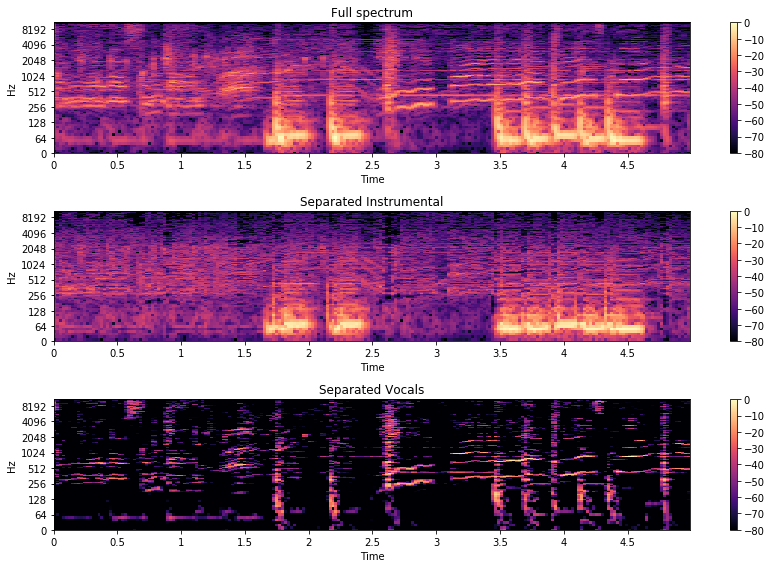

In [13]:
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_instrumental[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Separated Instrumental')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_vocals[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Separated Vocals')
plt.colorbar()
plt.tight_layout()
plt.show()

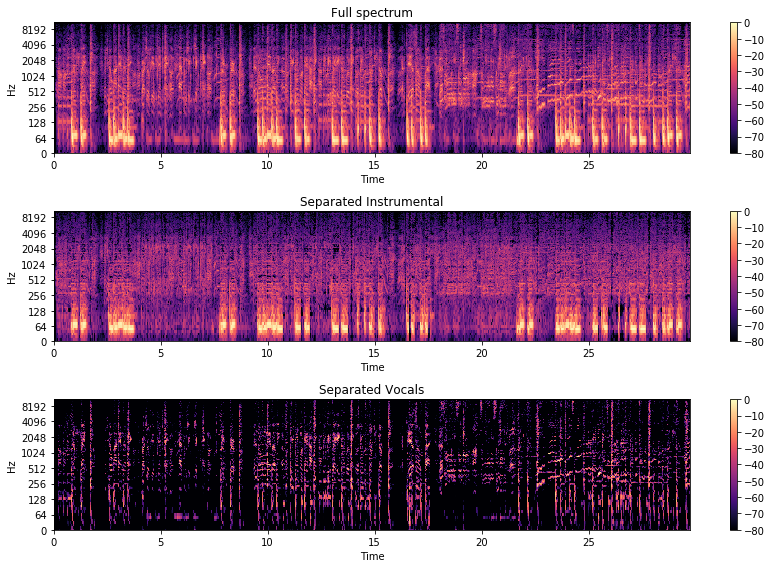

In [14]:
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_instrumental, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Separated Instrumental')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_vocals, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Separated Vocals')
plt.colorbar()
plt.tight_layout()
plt.show()

In [15]:
# Audio(data=y, rate=sr)

In [16]:
Audio(data=librosa.istft(S_instrumental * phase), rate=sr)

In [17]:
Audio(data=librosa.istft(S_vocals * phase), rate=sr)

In [18]:
yI, srI = librosa.load('proj/Are You That Somebody (Instrumental).mp3')
yA, srA = librosa.load('proj/Are You That Somebody (Acapella).mp3')

S_I, phaseI = librosa.magphase(librosa.stft(yI))
S_A, phaseA = librosa.magphase(librosa.stft(yA))

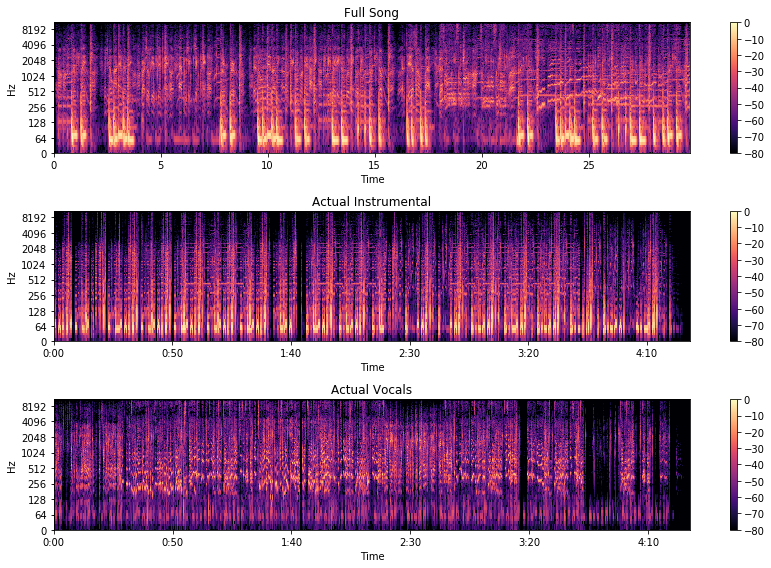

In [ ]:
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Full Song')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_I, ref=np.max),
                         y_axis='log', x_axis='time', sr=srI)
plt.title('Actual Instrumental')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_A, ref=np.max),
                         y_axis='log', x_axis='time', sr=srA)
plt.title('Actual Vocals')
plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(4, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_I, ref=np.max),
                         y_axis='log', x_axis='time', sr=srI)
plt.title('Actual Instrumental')
plt.colorbar()
plt.subplot(4, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_instrumental, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Separated Instrumental')
plt.colorbar()
plt.subplot(4, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_A, ref=np.max),
                         y_axis='log', x_axis='time', sr=srA)
plt.title('Actual Vocals')
plt.colorbar()
plt.subplot(4, 1, 4)
librosa.display.specshow(librosa.amplitude_to_db(S_vocals, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Separated Vocals')
plt.colorbar()
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [ ]:
# Audio(data=librosa.istft(S_I * phaseI), rate=srI)

In [ ]:
# Audio(data=librosa.istft(S_A * phaseA), rate=srA)

In [ ]:
#Showing multiple plots using subplot
plt.subplot(1, 2, 1) 
mfccI = librosa.feature.mfcc(yI, srI)   #Computing MFCC values
librosa.display.specshow(mfccI)
plt.title('Actual Instrumental')
plt.subplot(1, 2, 2)
mfcc_I = librosa.feature.mfcc(librosa.istft(S_instrumental * phase), sr)
librosa.display.specshow(mfcc_I)
plt.title('Separated Instrumental')
plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
# distI, costI, pathI = dtw(mfccI.T, mfcc_I.T, dist=lambda x, y: norm(x - y, ord=1))
# print("The normalized distance between instrumentals: ",distI)   # 0 for similar audios 

In [ ]:
#Showing multiple plots using subplot
plt.subplot(1, 2, 1) 
mfccA = librosa.feature.mfcc(yA, srA)   #Computing MFCC values
librosa.display.specshow(mfccA)
plt.title('Actual Vocals')
plt.subplot(1, 2, 2)
mfcc_A = librosa.feature.mfcc(librosa.istft(S_vocals * phase), sr)
librosa.display.specshow(mfcc_A)
plt.title('Separated Vocals')
plt.colorbar()
plt.tight_layout()
plt.show()

In [ ]:
# distA, costA, pathA = dtw(mfccA.T, mfcc_A.T, dist=lambda x, y: norm(x - y, ord=1))
# print("The normalized distance between acapellas: ",distA)   # 0 for similar audios 

In [ ]:
# oenvI = librosa.onset.onset_strength(y=yI, sr=srI, lag=2, max_size=5)
# tgramI = librosa.feature.tempogram(onset_envelope=oenvI, sr=srI, win_length=512)

# oenv_I = librosa.onset.onset_strength(y=librosa.istft(S_instrumental * phase), sr=sr, lag=2, max_size=5)
# tgram_I = librosa.feature.tempogram(onset_envelope=oenv_I, sr=sr, win_length=512)

# # And plot a distance matrix for each feature.
# RtgramI = scipy.spatial.distance.cdist(tgramI.T, tgram_I.T,
#                                       metric='seuclidean', V=1e-3 + np.std(tgramI, axis=1))

# oenvA = librosa.onset.onset_strength(y=yA, sr=srA, lag=2, max_size=5)
# tgramA = librosa.feature.tempogram(onset_envelope=oenvA, sr=srA, win_length=512)

# oenv_A = librosa.onset.onset_strength(y=librosa.istft(S_vocals * phase), sr=sr, lag=2, max_size=5)
# tgram_A = librosa.feature.tempogram(onset_envelope=oenv_A, sr=sr, win_length=512)

# # And plot a distance matrix for each feature.
# RtgramA = scipy.spatial.distance.cdist(tgramA.T, tgram_A.T,
#                                       metric='seuclidean', V=1e-3 + np.std(tgramA, axis=1))

In [ ]:
# plt.figure(figsize=(12, 4))
# plt.subplot(1,2,1)
# librosa.display.specshow(RtgramI, cmap='magma_r')
# plt.title('Tempogram distance Instrumental')
# plt.colorbar()

# plt.subplot(1,2,2)
# librosa.display.specshow(RtgramA, cmap='magma_r')
# plt.title('Tempogram distance Acapellas')
# plt.colorbar()
# plt.tight_layout()